In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
import time

In [5]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
import gym

In [7]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [8]:
###### PARAMS ######
learning_rate = 0.01
num_episodes = 10000
gamma=0.9999
#gamma=0.85
egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 500

report_interval=10

score_to_solve = 195

hidden_layer_size=64

replay_memory_size=50000

batch_size=32

update_target_frequency = 500

clip_error=False

double_dqn=True

In [9]:
env = gym.make('CartPole-v1')

In [10]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
#env = gym.wrappers.Monitor(env, '../mp4/cartpole-5',video_callable=lambda episode_id: episode_id%10==0)

In [11]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [12]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [13]:
o=torch.arange(20,dtype=torch.float32).view(-1,4).contiguous()

In [14]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity=capacity
        self.memory=[]
        self.position=0
        
    
    def push(self, state,
             action, new_state,
             reward, done):
        
            transition=(state,action,new_state,reward,done)
            
            if self.position>=len(self.memory):
                self.memory.append(transition)
            else:
                self.memory[self.position]=transition
                
            self.position=(self.position+1)%self.capacity
        
    
    def sample(self,batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    

In [15]:
class NeuralNetworkDueling(nn.Module):
    def __init__(self):
        super(NeuralNetworkDueling, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.advantage = nn.Linear(hidden_layer_size,number_of_outputs)
        self.value = nn.Linear(hidden_layer_size,1)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        
        #print('x shape {} and value:'.format(x.shape))
        #print(x.detach().cpu())
        
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        
        #print('output1 shape {} and value:'.format(output1.shape))
        #print(output1.detach().cpu())
        
        output_advantage=self.advantage(output1)
        output_value=self.value(output1)
        
        #print('output_advantage shape {} and value:'.format(output_advantage.shape))
        #print(output_advantage.detach().cpu())
        
        #print('output_value shape {} and value:'.format(output_value.shape))
        #print(output_value.detach().cpu())
        
        #print('output_advantage.mean shape {} and value:'.format(output_advantage.mean(dim=1,keepdim=True).shape))
        #print(output_advantage.mean(dim=1,keepdim=True).detach().cpu())
        
        output_final=output_value+output_advantage-output_advantage.mean(dim=1,keepdim=True)
        
        
        return output_final

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        
        return output2

In [17]:
class QNet_Agent():
    def __init__(self):
        
        self.nn = NeuralNetworkDueling().to(device)
        self.target_nn = NeuralNetworkDueling().to(device)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
        self.update_target_counter = 0
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state.unsqueeze(dim=0)).squeeze()
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self):
        
        if len(memory)<batch_size:
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor(reward).to(device)
        
        #the view call below is to transform into column vector
        #so that it can be used in the gather call
        #i.e. we will use it to pick out from the computed value
        #tensor only values indexed by selected action
        action=(torch.Tensor(action).view(-1,1).long()).to(device)
        #print('action: ')
        #print(action)
        #print('contiguous?', action.is_contiguous())
        done=torch.Tensor(done).to(device)
        
        #print('shape of: state, new state, reward, action, done:')
        #print(state.shape)
        #print(new_state.shape)
        #print(reward.shape)
        #print(action.shape)
        #print(done.shape)
        
        
        self.nn.eval()
        self.target_nn.eval()
            
            
        if double_dqn:
            #print('in double DQN')
            new_state_values_from_nn=self.nn(new_state).detach()
            #print('new_state_values_from_nn shape {} and value:'.format(new_state_values_from_nn.shape))
            #print(new_state_values_from_nn)
            max_new_state_indexes=torch.max(new_state_values_from_nn,dim=1)[1].view(-1,1)
            #print('max_new_state_indexes shape {} and value:'.format(max_new_state_indexes.shape))
            #print(max_new_state_indexes)
            new_state_values=self.target_nn(new_state).detach()
            #print('new_state_values shape {} and value:'.format(new_state_values.shape))
            #print(new_state_values)
            max_new_state_values=torch.gather(new_state_values,1,max_new_state_indexes).squeeze()
            #print('max_new_state_values shape {} and value:'.format(max_new_state_values.shape))
            #print(max_new_state_values)
        else:
            #print('in regular DQN')
            new_state_values=self.target_nn(new_state).detach()
            #print('new_state_values shape {} and value'.format(new_state_values.shape))
            #print(new_state_values)
        
            max_new_state_values=torch.max(new_state_values,dim=1)[0]
            #print('max_new_state_values shape {} and value'.format(max_new_state_values.shape))
            #print(max_new_state_values)
            
        target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
        
        #print('shape of: target_value')
        #print(target_value.shape)
        self.nn.train()
        
        #this will select only the values of the desired actions
        predicted_value=torch.gather(self.nn(state),1,action)
        #print('shape of: predicted_value')
        #print(predicted_value.shape)
        
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.clamp_(-1.0,1.0)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            #print("***********************")
            #print("UPDATING TARGET NETWORK")
            #print("update counter: {}".format(self.update_target_counter))
            #print("***********************")
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.update_target_counter+=1
        

In [18]:
memory=ExperienceReplay(replay_memory_size)

In [19]:
qnet_agent=QNet_Agent()

In [20]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [21]:
%%time

steps_total=np.full([num_episodes],-999,dtype=np.int32)

frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        memory.push(state, action, new_state,
                     reward, done)
        
        qnet_agent.optimize()
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(steps_total[i_episode-100:i_episode])/100
            
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(steps_total[i_episode-report_interval:i_episode])
                print("Recent average reward: {}".format(recent_avg_reward))
                if i_episode>100:
                    print("Reward over last 100: {}".format(mean_reward_100))
                full_avg_so_far=np.average(steps_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        

**** Episode  10 **** 
Recent average reward: 22.7
Average over all episodes so far: 22.7
epsilon: 0.5607172187074654
**** Episode  20 **** 
Recent average reward: 25.4
Average over all episodes so far: 24.05
epsilon: 0.3413653233673081
**** Episode  30 **** 
Recent average reward: 14.1
Average over all episodes so far: 20.733333333333334
epsilon: 0.259940143382758
**** Episode  40 **** 
Recent average reward: 18.6
Average over all episodes so far: 20.2
epsilon: 0.18298786762895167
**** Episode  50 **** 
Recent average reward: 19.1
Average over all episodes so far: 19.98
epsilon: 0.12782747316285445
**** Episode  60 **** 
Recent average reward: 18.0
Average over all episodes so far: 19.65
epsilon: 0.0925349188620835
**** Episode  70 **** 
Recent average reward: 37.6
Average over all episodes so far: 22.214285714285715
epsilon: 0.04875351505283206
**** Episode  80 **** 
Recent average reward: 35.9
Average over all episodes so far: 23.925
epsilon: 0.026596991810836475
**** Episode  90 **

**** Episode  580 **** 
Recent average reward: 500.0
Reward over last 100: 410.33
Average over all episodes so far: 219.7396551724138
epsilon: 0.01
**** Episode  590 **** 
Recent average reward: 465.7
Reward over last 100: 411.45
Average over all episodes so far: 223.90847457627117
epsilon: 0.01
**** Episode  600 **** 
Recent average reward: 500.0
Reward over last 100: 420.46
Average over all episodes so far: 228.51
epsilon: 0.01
**** Episode  610 **** 
Recent average reward: 500.0
Reward over last 100: 425.39
Average over all episodes so far: 232.9606557377049
epsilon: 0.01
**** Episode  620 **** 
Recent average reward: 500.0
Reward over last 100: 437.78
Average over all episodes so far: 237.26774193548388
epsilon: 0.01
**** Episode  630 **** 
Recent average reward: 468.2
Reward over last 100: 449.81
Average over all episodes so far: 240.93333333333334
epsilon: 0.01
**** Episode  640 **** 
Recent average reward: 382.3
Reward over last 100: 446.26
Average over all episodes so far: 243.

**** Episode  1140 **** 
Recent average reward: 500.0
Reward over last 100: 366.05
Average over all episodes so far: 308.5912280701754
epsilon: 0.01
**** Episode  1150 **** 
Recent average reward: 500.0
Reward over last 100: 370.94
Average over all episodes so far: 310.25565217391306
epsilon: 0.01
**** Episode  1160 **** 
Recent average reward: 445.8
Reward over last 100: 385.63
Average over all episodes so far: 311.42413793103447
epsilon: 0.01
**** Episode  1170 **** 
Recent average reward: 432.9
Reward over last 100: 408.59
Average over all episodes so far: 312.46239316239314
epsilon: 0.01
**** Episode  1180 **** 
Recent average reward: 500.0
Reward over last 100: 434.13
Average over all episodes so far: 314.05169491525425
epsilon: 0.01
**** Episode  1190 **** 
Recent average reward: 330.0
Reward over last 100: 436.59
Average over all episodes so far: 314.1857142857143
epsilon: 0.01
**** Episode  1200 **** 
Recent average reward: 303.2
Reward over last 100: 442.91
Average over all ep

**** Episode  1700 **** 
Recent average reward: 410.3
Reward over last 100: 444.51
Average over all episodes so far: 342.9894117647059
epsilon: 0.01
**** Episode  1710 **** 
Recent average reward: 468.5
Reward over last 100: 448.8
Average over all episodes so far: 343.7233918128655
epsilon: 0.01
**** Episode  1720 **** 
Recent average reward: 480.7
Reward over last 100: 448.75
Average over all episodes so far: 344.51976744186044
epsilon: 0.01
**** Episode  1730 **** 
Recent average reward: 500.0
Reward over last 100: 450.75
Average over all episodes so far: 345.4184971098266
epsilon: 0.01
**** Episode  1740 **** 
Recent average reward: 500.0
Reward over last 100: 450.75
Average over all episodes so far: 346.30689655172415
epsilon: 0.01
**** Episode  1750 **** 
Recent average reward: 439.2
Reward over last 100: 444.67
Average over all episodes so far: 346.8377142857143
epsilon: 0.01
**** Episode  1760 **** 
Recent average reward: 414.2
Reward over last 100: 436.09
Average over all episo

**** Episode  2260 **** 
Recent average reward: 473.8
Reward over last 100: 427.36
Average over all episodes so far: 358.8615044247788
epsilon: 0.01
**** Episode  2270 **** 
Recent average reward: 399.3
Reward over last 100: 417.29
Average over all episodes so far: 359.0396475770925
epsilon: 0.01
**** Episode  2280 **** 
Recent average reward: 386.3
Reward over last 100: 405.92
Average over all episodes so far: 359.1592105263158
epsilon: 0.01
**** Episode  2290 **** 
Recent average reward: 463.5
Reward over last 100: 402.27
Average over all episodes so far: 359.6148471615721
epsilon: 0.01
**** Episode  2300 **** 
Recent average reward: 391.4
Reward over last 100: 391.41
Average over all episodes so far: 359.75304347826085
epsilon: 0.01
**** Episode  2310 **** 
Recent average reward: 449.0
Reward over last 100: 386.31
Average over all episodes so far: 360.1393939393939
epsilon: 0.01
**** Episode  2320 **** 
Recent average reward: 471.2
Reward over last 100: 385.17
Average over all episo

**** Episode  2820 **** 
Recent average reward: 361.0
Reward over last 100: 432.0
Average over all episodes so far: 379.68617021276594
epsilon: 0.01
**** Episode  2830 **** 
Recent average reward: 344.5
Reward over last 100: 426.84
Average over all episodes so far: 379.5618374558304
epsilon: 0.01
**** Episode  2840 **** 
Recent average reward: 347.7
Reward over last 100: 411.81
Average over all episodes so far: 379.4496478873239
epsilon: 0.01
**** Episode  2850 **** 
Recent average reward: 326.1
Reward over last 100: 403.55
Average over all episodes so far: 379.2624561403509
epsilon: 0.01
**** Episode  2860 **** 
Recent average reward: 418.6
Reward over last 100: 402.42
Average over all episodes so far: 379.4
epsilon: 0.01
**** Episode  2870 **** 
Recent average reward: 429.4
Reward over last 100: 402.69
Average over all episodes so far: 379.57421602787457
epsilon: 0.01
**** Episode  2880 **** 
Recent average reward: 431.7
Reward over last 100: 396.65
Average over all episodes so far: 

**** Episode  3380 **** 
Recent average reward: 239.8
Reward over last 100: 364.12
Average over all episodes so far: 388.06242603550294
epsilon: 0.01
**** Episode  3390 **** 
Recent average reward: 430.3
Reward over last 100: 369.31
Average over all episodes so far: 388.1870206489676
epsilon: 0.01
**** Episode  3400 **** 
Recent average reward: 478.7
Reward over last 100: 367.18
Average over all episodes so far: 388.45323529411763
epsilon: 0.01
**** Episode  3410 **** 
Recent average reward: 328.6
Reward over last 100: 359.39
Average over all episodes so far: 388.27771260997065
epsilon: 0.01
**** Episode  3420 **** 
Recent average reward: 210.8
Reward over last 100: 335.48
Average over all episodes so far: 387.75877192982455
epsilon: 0.01
**** Episode  3430 **** 
Recent average reward: 281.9
Reward over last 100: 321.55
Average over all episodes so far: 387.45014577259474
epsilon: 0.01
**** Episode  3440 **** 
Recent average reward: 346.8
Reward over last 100: 326.96
Average over all e

**** Episode  3930 **** 
Recent average reward: 500.0
Reward over last 100: 493.98
Average over all episodes so far: 398.0844783715013
epsilon: 0.01
**** Episode  3940 **** 
Recent average reward: 500.0
Reward over last 100: 495.8
Average over all episodes so far: 398.3431472081218
epsilon: 0.01
**** Episode  3950 **** 
Recent average reward: 500.0
Reward over last 100: 495.8
Average over all episodes so far: 398.6005063291139
epsilon: 0.01
**** Episode  3960 **** 
Recent average reward: 500.0
Reward over last 100: 495.8
Average over all episodes so far: 398.85656565656564
epsilon: 0.01
**** Episode  3970 **** 
Recent average reward: 500.0
Reward over last 100: 499.26
Average over all episodes so far: 399.11133501259445
epsilon: 0.01
**** Episode  3980 **** 
Recent average reward: 425.4
Reward over last 100: 492.54
Average over all episodes so far: 399.1773869346734
epsilon: 0.01
**** Episode  3990 **** 
Recent average reward: 396.0
Reward over last 100: 482.14
Average over all episode

**** Episode  4490 **** 
Recent average reward: 444.2
Reward over last 100: 480.15
Average over all episodes so far: 406.4988864142539
epsilon: 0.01
**** Episode  4500 **** 
Recent average reward: 302.4
Reward over last 100: 460.39
Average over all episodes so far: 406.26755555555553
epsilon: 0.01
**** Episode  4510 **** 
Recent average reward: 213.5
Reward over last 100: 431.74
Average over all episodes so far: 405.840133037694
epsilon: 0.01
**** Episode  4520 **** 
Recent average reward: 179.8
Reward over last 100: 401.74
Average over all episodes so far: 405.3400442477876
epsilon: 0.01
**** Episode  4530 **** 
Recent average reward: 134.0
Reward over last 100: 365.14
Average over all episodes so far: 404.741059602649
epsilon: 0.01
**** Episode  4540 **** 
Recent average reward: 136.7
Reward over last 100: 328.81
Average over all episodes so far: 404.15066079295156
epsilon: 0.01
**** Episode  4550 **** 
Recent average reward: 138.1
Reward over last 100: 292.62
Average over all episod

**** Episode  5040 **** 
Recent average reward: 360.1
Reward over last 100: 394.81
Average over all episodes so far: 401.2875
epsilon: 0.01
**** Episode  5050 **** 
Recent average reward: 430.0
Reward over last 100: 391.87
Average over all episodes so far: 401.3443564356436
epsilon: 0.01
**** Episode  5060 **** 
Recent average reward: 500.0
Reward over last 100: 391.87
Average over all episodes so far: 401.5393280632411
epsilon: 0.01
**** Episode  5070 **** 
Recent average reward: 358.7
Reward over last 100: 377.74
Average over all episodes so far: 401.45483234714004
epsilon: 0.01
**** Episode  5080 **** 
Recent average reward: 409.5
Reward over last 100: 374.08
Average over all episodes so far: 401.4706692913386
epsilon: 0.01
**** Episode  5090 **** 
Recent average reward: 460.3
Reward over last 100: 382.66
Average over all episodes so far: 401.5862475442043
epsilon: 0.01
**** Episode  5100 **** 
Recent average reward: 253.7
Reward over last 100: 380.73
Average over all episodes so fa

**** Episode  5590 **** 
Recent average reward: 367.2
Reward over last 100: 428.76
Average over all episodes so far: 401.6098389982111
epsilon: 0.01
**** Episode  5600 **** 
Recent average reward: 468.0
Reward over last 100: 460.67
Average over all episodes so far: 401.72839285714286
epsilon: 0.01
**** Episode  5610 **** 
Recent average reward: 409.1
Reward over last 100: 465.57
Average over all episodes so far: 401.7415329768271
epsilon: 0.01
**** Episode  5620 **** 
Recent average reward: 500.0
Reward over last 100: 465.57
Average over all episodes so far: 401.9163701067616
epsilon: 0.01
**** Episode  5630 **** 
Recent average reward: 500.0
Reward over last 100: 465.57
Average over all episodes so far: 402.09058614564833
epsilon: 0.01
**** Episode  5640 **** 
Recent average reward: 500.0
Reward over last 100: 465.57
Average over all episodes so far: 402.26418439716315
epsilon: 0.01
**** Episode  5650 **** 
Recent average reward: 499.4
Reward over last 100: 465.51
Average over all epi

**** Episode  6140 **** 
Recent average reward: 50.2
Reward over last 100: 262.56
Average over all episodes so far: 400.72345276872966
epsilon: 0.01
**** Episode  6150 **** 
Recent average reward: 192.2
Reward over last 100: 233.02
Average over all episodes so far: 400.38439024390243
epsilon: 0.01
**** Episode  6160 **** 
Recent average reward: 313.4
Reward over last 100: 229.34
Average over all episodes so far: 400.2431818181818
epsilon: 0.01
**** Episode  6170 **** 
Recent average reward: 405.6
Reward over last 100: 250.32
Average over all episodes so far: 400.2518638573744
epsilon: 0.01
**** Episode  6180 **** 
Recent average reward: 412.4
Reward over last 100: 256.11
Average over all episodes so far: 400.2715210355987
epsilon: 0.01
**** Episode  6190 **** 
Recent average reward: 414.6
Reward over last 100: 262.79
Average over all episodes so far: 400.2946688206785
epsilon: 0.01
**** Episode  6200 **** 
Recent average reward: 500.0
Reward over last 100: 285.6
Average over all episod

**** Episode  6700 **** 
Recent average reward: 500.0
Reward over last 100: 409.36
Average over all episodes so far: 401.7268656716418
epsilon: 0.01
**** Episode  6710 **** 
Recent average reward: 500.0
Reward over last 100: 413.06
Average over all episodes so far: 401.87332339791357
epsilon: 0.01
**** Episode  6720 **** 
Recent average reward: 500.0
Reward over last 100: 416.74
Average over all episodes so far: 402.01934523809524
epsilon: 0.01
**** Episode  6730 **** 
Recent average reward: 475.4
Reward over last 100: 414.28
Average over all episodes so far: 402.12838038632987
epsilon: 0.01
**** Episode  6740 **** 
Recent average reward: 496.2
Reward over last 100: 415.44
Average over all episodes so far: 402.2679525222552
epsilon: 0.01
**** Episode  6750 **** 
Recent average reward: 500.0
Reward over last 100: 418.9
Average over all episodes so far: 402.41274074074073
epsilon: 0.01
**** Episode  6760 **** 
Recent average reward: 500.0
Reward over last 100: 445.22
Average over all epi

**** Episode  7260 **** 
Recent average reward: 385.2
Reward over last 100: 452.42
Average over all episodes so far: 406.4988980716253
epsilon: 0.01
**** Episode  7270 **** 
Recent average reward: 398.3
Reward over last 100: 456.25
Average over all episodes so far: 406.4876203576341
epsilon: 0.01
**** Episode  7280 **** 
Recent average reward: 369.2
Reward over last 100: 447.18
Average over all episodes so far: 406.4364010989011
epsilon: 0.01
**** Episode  7290 **** 
Recent average reward: 464.4
Reward over last 100: 448.72
Average over all episodes so far: 406.5159122085048
epsilon: 0.01
**** Episode  7300 **** 
Recent average reward: 391.8
Reward over last 100: 438.51
Average over all episodes so far: 406.49575342465755
epsilon: 0.01
**** Episode  7310 **** 
Recent average reward: 412.6
Reward over last 100: 429.77
Average over all episodes so far: 406.50410396716825
epsilon: 0.01
**** Episode  7320 **** 
Recent average reward: 380.1
Reward over last 100: 417.78
Average over all epis

**** Episode  7810 **** 
Recent average reward: 478.6
Reward over last 100: 490.16
Average over all episodes so far: 409.2121638924456
epsilon: 0.01
**** Episode  7820 **** 
Recent average reward: 500.0
Reward over last 100: 490.16
Average over all episodes so far: 409.3282608695652
epsilon: 0.01
**** Episode  7830 **** 
Recent average reward: 389.8
Reward over last 100: 479.14
Average over all episodes so far: 409.30332056194123
epsilon: 0.01
**** Episode  7840 **** 
Recent average reward: 338.9
Reward over last 100: 463.03
Average over all episodes so far: 409.2135204081633
epsilon: 0.01
**** Episode  7850 **** 
Recent average reward: 500.0
Reward over last 100: 463.03
Average over all episodes so far: 409.3291719745223
epsilon: 0.01
**** Episode  7860 **** 
Recent average reward: 500.0
Reward over last 100: 463.03
Average over all episodes so far: 409.4445292620865
epsilon: 0.01
**** Episode  7870 **** 
Recent average reward: 500.0
Reward over last 100: 463.03
Average over all episo

**** Episode  8370 **** 
Recent average reward: 500.0
Reward over last 100: 469.43
Average over all episodes so far: 411.1709677419355
epsilon: 0.01
**** Episode  8380 **** 
Recent average reward: 463.9
Reward over last 100: 467.09
Average over all episodes so far: 411.23389021479716
epsilon: 0.01
**** Episode  8390 **** 
Recent average reward: 328.9
Reward over last 100: 456.5
Average over all episodes so far: 411.1357568533969
epsilon: 0.01
**** Episode  8400 **** 
Recent average reward: 427.8
Reward over last 100: 451.28
Average over all episodes so far: 411.15559523809526
epsilon: 0.01
**** Episode  8410 **** 
Recent average reward: 157.7
Reward over last 100: 417.05
Average over all episodes so far: 410.85422116527945
epsilon: 0.01
**** Episode  8420 **** 
Recent average reward: 280.8
Reward over last 100: 395.13
Average over all episodes so far: 410.69976247030877
epsilon: 0.01
**** Episode  8430 **** 
Recent average reward: 363.9
Reward over last 100: 381.52
Average over all epi

**** Episode  8920 **** 
Recent average reward: 256.5
Reward over last 100: 358.79
Average over all episodes so far: 405.1762331838565
epsilon: 0.01
**** Episode  8930 **** 
Recent average reward: 173.8
Reward over last 100: 328.93
Average over all episodes so far: 404.91713325867863
epsilon: 0.01
**** Episode  8940 **** 
Recent average reward: 245.9
Reward over last 100: 303.52
Average over all episodes so far: 404.7392617449664
epsilon: 0.01
**** Episode  8950 **** 
Recent average reward: 219.7
Reward over last 100: 280.36
Average over all episodes so far: 404.53251396648045
epsilon: 0.01
**** Episode  8960 **** 
Recent average reward: 360.6
Reward over last 100: 274.84
Average over all episodes so far: 404.48348214285716
epsilon: 0.01
**** Episode  8970 **** 
Recent average reward: 326.0
Reward over last 100: 267.79
Average over all episodes so far: 404.39598662207356
epsilon: 0.01
**** Episode  8980 **** 
Recent average reward: 420.0
Reward over last 100: 284.66
Average over all ep

**** Episode  9470 **** 
Recent average reward: 500.0
Reward over last 100: 475.97
Average over all episodes so far: 403.91351636747623
epsilon: 0.01
**** Episode  9480 **** 
Recent average reward: 425.0
Reward over last 100: 473.43
Average over all episodes so far: 403.9357594936709
epsilon: 0.01
**** Episode  9490 **** 
Recent average reward: 500.0
Reward over last 100: 478.16
Average over all episodes so far: 404.03698630136984
epsilon: 0.01
**** Episode  9500 **** 
Recent average reward: 500.0
Reward over last 100: 478.16
Average over all episodes so far: 404.138
epsilon: 0.01
**** Episode  9510 **** 
Recent average reward: 500.0
Reward over last 100: 478.16
Average over all episodes so far: 404.2388012618297
epsilon: 0.01
**** Episode  9520 **** 
Recent average reward: 491.8
Reward over last 100: 484.47
Average over all episodes so far: 404.33077731092436
epsilon: 0.01
**** Episode  9530 **** 
Recent average reward: 500.0
Reward over last 100: 484.47
Average over all episodes so f

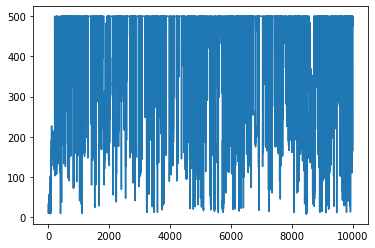

In [22]:
plt.plot(steps_total)
plt.show()

In [23]:
print("Average number of steps: {}". format(np.average(steps_total)))

Average number of steps: 406.3382


In [24]:
print("Average number of steps=reward: {}". format(np.average(steps_total)))
print("Average number of steps=reward in last 100 episodes: {}". format(np.average(steps_total[-100:])))



Average number of steps=reward: 406.3382
Average number of steps=reward in last 100 episodes: 471.99


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

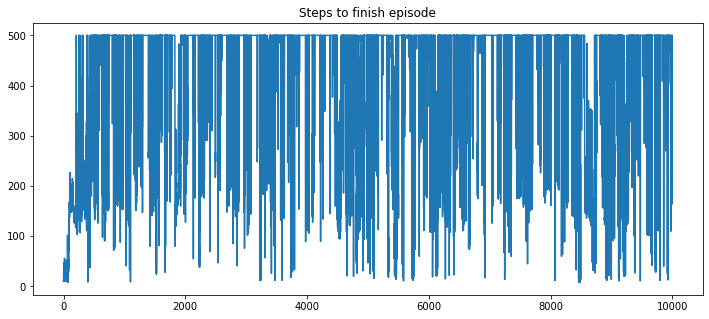

In [25]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total)
plt.show()